In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../scripts')

from plot_functions import plot_job_summary_violin, sci_cat_pie_chart, subplot_util_dist, plot_util_dist, plot_power_dist, plot_energy_dist,  plot_tif_dist, plot_sif_dist, subplot_ai_dist, plot_ai_dist, plot_fp_heatmap, plot_ratio_dist
from metric_analysis import find_max_ai, find_mean_ai, check_metrics, clean_and_compare #find_tif_power


In [2]:
vasp_data = pd.read_parquet('../notebooks/VASP.parquet')
lammps_data = pd.read_parquet('../notebooks/LAMMPS.parquet')
espresso_data = pd.read_parquet('../notebooks/ESPRESSO.parquet')
atlas_data = pd.read_parquet('../notebooks/ATLAS.parquet')
e3sm_data = pd.read_parquet('../notebooks/E3SM.parquet')


In [3]:
def summarize_all(vasp_data):
    # Check columns
    #vasp_data.columns.to_list()
    
    print(f"Parsed {len(vasp_data)} job records\n")
    print("*******")
    print(f"Requested Memory: Min {min(vasp_data['req_mem_mb'])} - Median {(vasp_data['req_mem_mb'].median())} - Max {max(vasp_data['req_mem_mb'])} MB")
    print(f"Requested GPU: Min {min(vasp_data['req_gpus'])} - Median {(vasp_data['req_gpus'].median())} - Max {max(vasp_data['req_gpus'])} GPUs")
    print(f"Requested Number of Node: Min {min(vasp_data['req_node'])} - Median {(vasp_data['req_node'].median())} - Max {max(vasp_data['req_node'])} nodes")
    print(f"Allocated Number of Nodes: Min {min(vasp_data['AllocNodes'])} - Median {(vasp_data['AllocNodes'].median())} - Max {max(vasp_data['AllocNodes'])} nodes")
    print(f"Requested CPU: Min {min(vasp_data['req_cpu'])} - Median {(vasp_data['req_cpu'].median())} - Max {max(vasp_data['req_cpu'])} CPUs")
    print(f"Requested Time: Min {min(vasp_data['req_time'])} - Median {(vasp_data['req_time'].median())} - Max {max(vasp_data['req_time'])} seconds")
    
    print("*******")
    print(f"Average Power Utilization per Job: {min(vasp_data['avg_power'])} - {max(vasp_data['avg_power'])} W")
    print(f"Maximum Power Utilization per Job: {min(vasp_data['max_power'])} - {max(vasp_data['max_power'])} W")
    print("*******\n")
    print(f"Number of unique users: {vasp_data['User'].nunique()}")
    print(f"Number of unique users (UID): {vasp_data['UID'].nunique()}")
    print(f"Number of unique accounts: {vasp_data['Account'].nunique()}")
    print(f"Number of unique categories: {vasp_data['Category'].nunique()}")
    print(f"Number of unique job names: {vasp_data['JobName'].nunique()}")

    node_bins = [1, 2, 4, 8, 16, np.inf] 
    node_labels = ['1', '[2, 4)' , '[4, 8)', '[8, 16)', '>=16']
    hrs_bins = [0, 1, 2, 6, 12, 24] 
    hrs_labels = ['[0, 1)', '[1, 2)' , '[2, 6)', '[6, 12)', '[12, 24)']

    vasp_data['node_group'] = pd.cut(vasp_data['req_node'], bins=node_bins, labels=node_labels, right=False)
    print(vasp_data['node_group'].value_counts(normalize=True).sort_index() * 100)

    vasp_data['texec_hrs'] = vasp_data['ElapsedSecs']/3600
    vasp_data['texec_group'] = pd.cut(vasp_data['texec_hrs'], bins=hrs_bins, labels=hrs_labels, right=False)
    print(vasp_data['texec_group'].value_counts(normalize=True).sort_index() * 100)

    # ---- GPU node-hour binning ----
    gpu_jobs = vasp_data[vasp_data['req_gpus'] > 0].copy()
    gpu_jobs['gpu_node_hrs'] = gpu_jobs['AllocNodes'] * gpu_jobs['texec_hrs']

    gpu_node_hrs_bins = [0, 1, 5, 10, 50, np.inf]
    gpu_node_hrs_labels = ['[0,1)', '[1,5)', '[5,10)', '[10,50)', '>=50']

    gpu_jobs['gpu_node_hrs_group'] = pd.cut(
        gpu_jobs['gpu_node_hrs'],
        bins=gpu_node_hrs_bins,
        labels=gpu_node_hrs_labels,
        right=False
    )

    print("*******")
    print("GPU Node-Hours Distribution (%):")
    print(gpu_jobs['gpu_node_hrs_group']
          .value_counts(normalize=True)
          .sort_index() * 100)

print("*******\n")
print("VASP\n")
print("*******\n")
summarize_all(vasp_data)


*******

VASP

*******

Parsed 32322 job records

*******
Requested Memory: Min 229902 - Median 229902.0 - Max 34485300 MB
Requested GPU: Min 4 - Median 4.0 - Max 600 GPUs
Requested Number of Node: Min 1 - Median 1.0 - Max 150 nodes
Allocated Number of Nodes: Min 1.0 - Median 1.0 - Max 150.0 nodes
Requested CPU: Min 128 - Median 128.0 - Max 19200 CPUs
Requested Time: Min 300.0 - Median 780.0 - Max 172800.0 seconds
*******
Average Power Utilization per Job: 50.97953709198813 - 35184372088959.11 W
Maximum Power Utilization per Job: 52.521 - 140737488355330.0 W
*******

Number of unique users: 128
Number of unique users (UID): 128
Number of unique accounts: 78
Number of unique categories: 15
Number of unique job names: 19949
node_group
1          86.659241
[2, 4)     10.707877
[4, 8)      2.273993
[8, 16)     0.266073
>=16        0.092816
Name: proportion, dtype: float64
texec_group
[0, 1)      96.042943
[1, 2)       1.039540
[2, 6)       1.649032
[6, 12)      0.618774
[12, 24)     0.6497

In [4]:
print("*******\n")
print("LAMMPS\n")
print("*******\n")
summarize_all(lammps_data)



*******

LAMMPS

*******

Parsed 134 job records

*******
Requested Memory: Min 225280 - Median 229902.0 - Max 5747550 MB
Requested GPU: Min 4 - Median 4.0 - Max 100 GPUs
Requested Number of Node: Min 1 - Median 1.0 - Max 25 nodes
Allocated Number of Nodes: Min 1.0 - Median 1.0 - Max 25.0 nodes
Requested CPU: Min 128 - Median 128.0 - Max 3200 CPUs
Requested Time: Min 5400.0 - Median 25170.0 - Max 172800.0 seconds
*******
Average Power Utilization per Job: 51.417312499999994 - 294.21900813786505 W
Maximum Power Utilization per Job: 53.745 - 423.62 W
*******

Number of unique users: 8
Number of unique users (UID): 8
Number of unique accounts: 8
Number of unique categories: 6
Number of unique job names: 19
node_group
1          86.567164
[2, 4)      0.000000
[4, 8)      0.000000
[8, 16)     2.238806
>=16       11.194030
Name: proportion, dtype: float64
texec_group
[0, 1)      58.208955
[1, 2)       7.462687
[2, 6)      20.149254
[6, 12)      9.701493
[12, 24)     4.477612
Name: proportion

In [5]:
print("*******\n")
print("ESPRESSO\n")
print("*******\n")
summarize_all(espresso_data)



*******

ESPRESSO

*******

Parsed 363 job records

*******
Requested Memory: Min 229902 - Median 919608.0 - Max 4368138 MB
Requested GPU: Min 4 - Median 16.0 - Max 76 GPUs
Requested Number of Node: Min 1 - Median 4.0 - Max 19 nodes
Allocated Number of Nodes: Min 1.0 - Median 4.0 - Max 19.0 nodes
Requested CPU: Min 128 - Median 512.0 - Max 2432 CPUs
Requested Time: Min 120.0 - Median 7200.0 - Max 172800.0 seconds
*******
Average Power Utilization per Job: 53.42658333333333 - 6350683212.330486 W
Maximum Power Utilization per Job: 54.381 - 140737488355330.0 W
*******

Number of unique users: 33
Number of unique users (UID): 33
Number of unique accounts: 19
Number of unique categories: 8
Number of unique job names: 104
node_group
1          21.763085
[2, 4)     13.774105
[4, 8)     27.272727
[8, 16)    31.404959
>=16        5.785124
Name: proportion, dtype: float64
texec_group
[0, 1)      68.595041
[1, 2)      10.468320
[2, 6)      16.253444
[6, 12)      1.652893
[12, 24)     3.030303
Nam

In [6]:
print("*******\n")
print("ATLAS\n")
print("*******\n")
summarize_all(atlas_data)



*******

ATLAS

*******

Parsed 655 job records

*******
Requested Memory: Min 229902 - Median 229902.0 - Max 117709824 MB
Requested GPU: Min 4 - Median 4.0 - Max 2048 GPUs
Requested Number of Node: Min 1 - Median 1.0 - Max 512 nodes
Allocated Number of Nodes: Min 1.0 - Median 1.0 - Max 512.0 nodes
Requested CPU: Min 128 - Median 128.0 - Max 65536 CPUs
Requested Time: Min 480.0 - Median 10800.0 - Max 172800.0 seconds
*******
Average Power Utilization per Job: 50.51750173526757 - 2932031007552.796 W
Maximum Power Utilization per Job: 53.745 - 140737488355330.0 W
*******

Number of unique users: 50
Number of unique users (UID): 50
Number of unique accounts: 41
Number of unique categories: 24
Number of unique job names: 124
node_group
1          65.648855
[2, 4)      9.618321
[4, 8)      1.984733
[8, 16)     3.206107
>=16       19.541985
Name: proportion, dtype: float64
texec_group
[0, 1)      48.396947
[1, 2)      14.198473
[2, 6)      29.618321
[6, 12)      5.648855
[12, 24)     2.13740

In [7]:
print("*******\n")
print("E3SM\n")
print("*******\n")
summarize_all(e3sm_data)



*******

E3SM

*******

Parsed 267 job records

*******
Requested Memory: Min 229902 - Median 229902.0 - Max 117709824 MB
Requested GPU: Min 4 - Median 4.0 - Max 2048 GPUs
Requested Number of Node: Min 1 - Median 1.0 - Max 512 nodes
Allocated Number of Nodes: Min 1.0 - Median 1.0 - Max 512.0 nodes
Requested CPU: Min 128 - Median 128.0 - Max 65536 CPUs
Requested Time: Min 1200.0 - Median 1920.0 - Max 18000.0 seconds
*******
Average Power Utilization per Job: 53.06916666666667 - 338311270182.7575 W
Maximum Power Utilization per Job: 53.681 - 140737488355330.0 W
*******

Number of unique users: 11
Number of unique users (UID): 11
Number of unique accounts: 7
Number of unique categories: 4
Number of unique job names: 259
node_group
1          53.558052
[2, 4)     24.719101
[4, 8)      6.741573
[8, 16)     4.868914
>=16       10.112360
Name: proportion, dtype: float64
texec_group
[0, 1)      98.127341
[1, 2)       1.123596
[2, 6)       0.749064
[6, 12)      0.000000
[12, 24)     0.000000
Na

CDF and PDF Plots

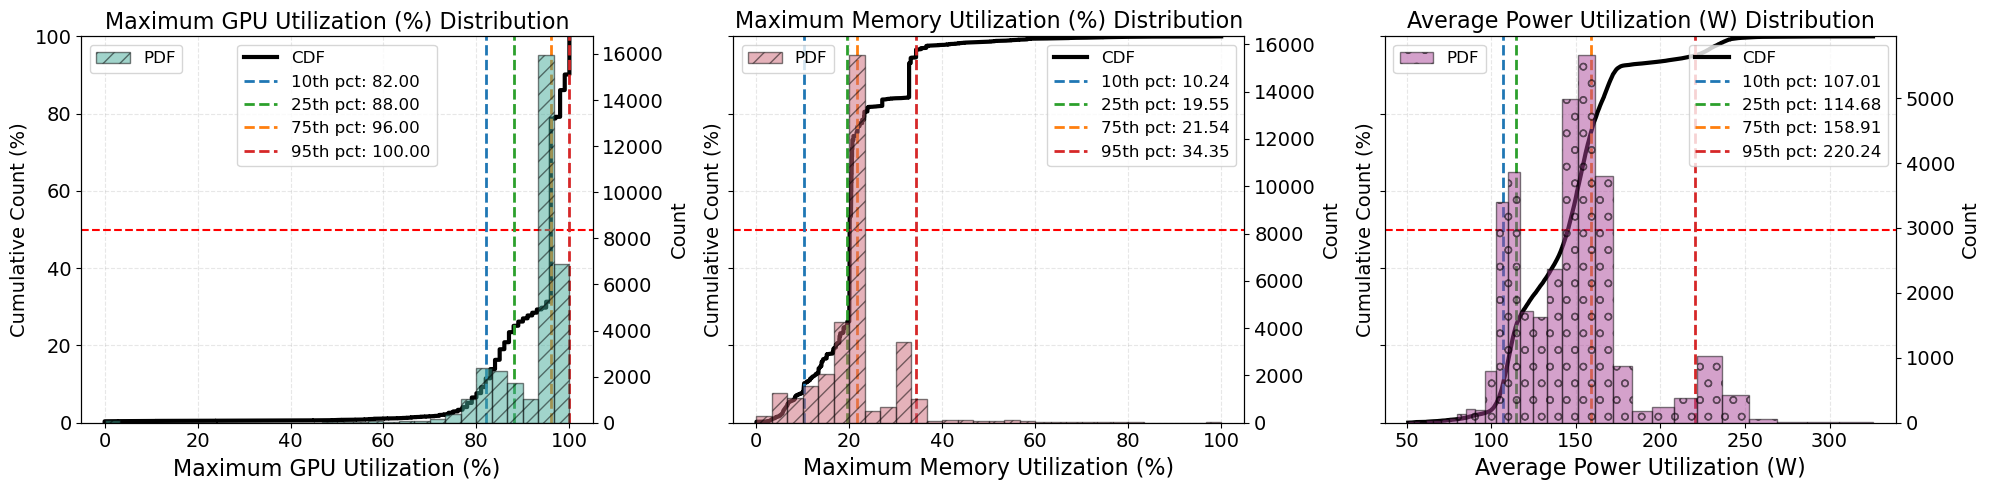

In [8]:
subplot_util_dist(vasp_data, 'gpu_utilization_max' , 'mem_util_max', 'avg_power','Perlmutter VASP Jobs Resource Utilization Distributions (March 2025)' , '#44AA99', '#CC6677', '#AA4499' )


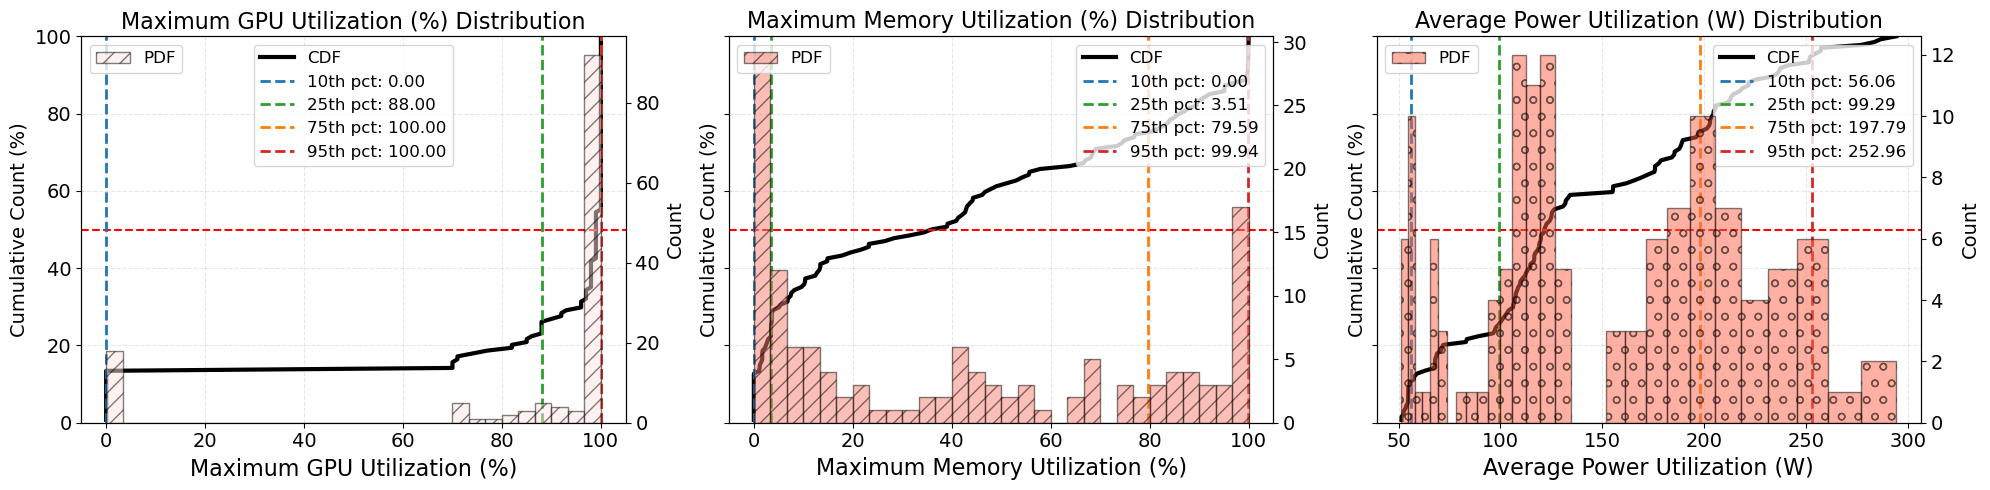

In [9]:
subplot_util_dist(lammps_data, 'gpu_utilization_max' , 'mem_util_max', 'avg_power','Perlmutter LAMMPS Jobs Resource Utilization Distributions (March 2025)', 'mistyrose', 'salmon', 'tomato' )


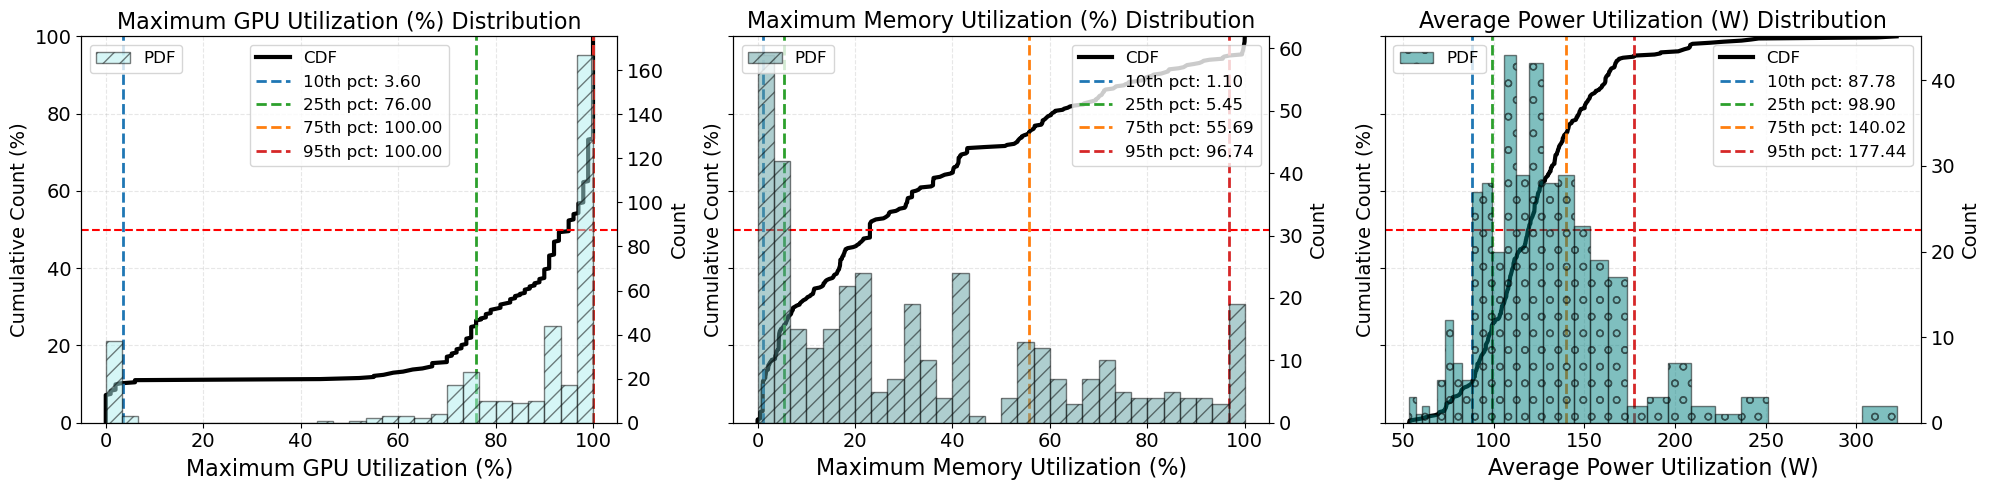

In [10]:
subplot_util_dist(espresso_data, 'gpu_utilization_max' , 'mem_util_max', 'avg_power', 'Perlmutter Espresso Jobs Resource Utilization Distributions (March 2025)', 'paleturquoise', 'cadetblue', 'teal' )


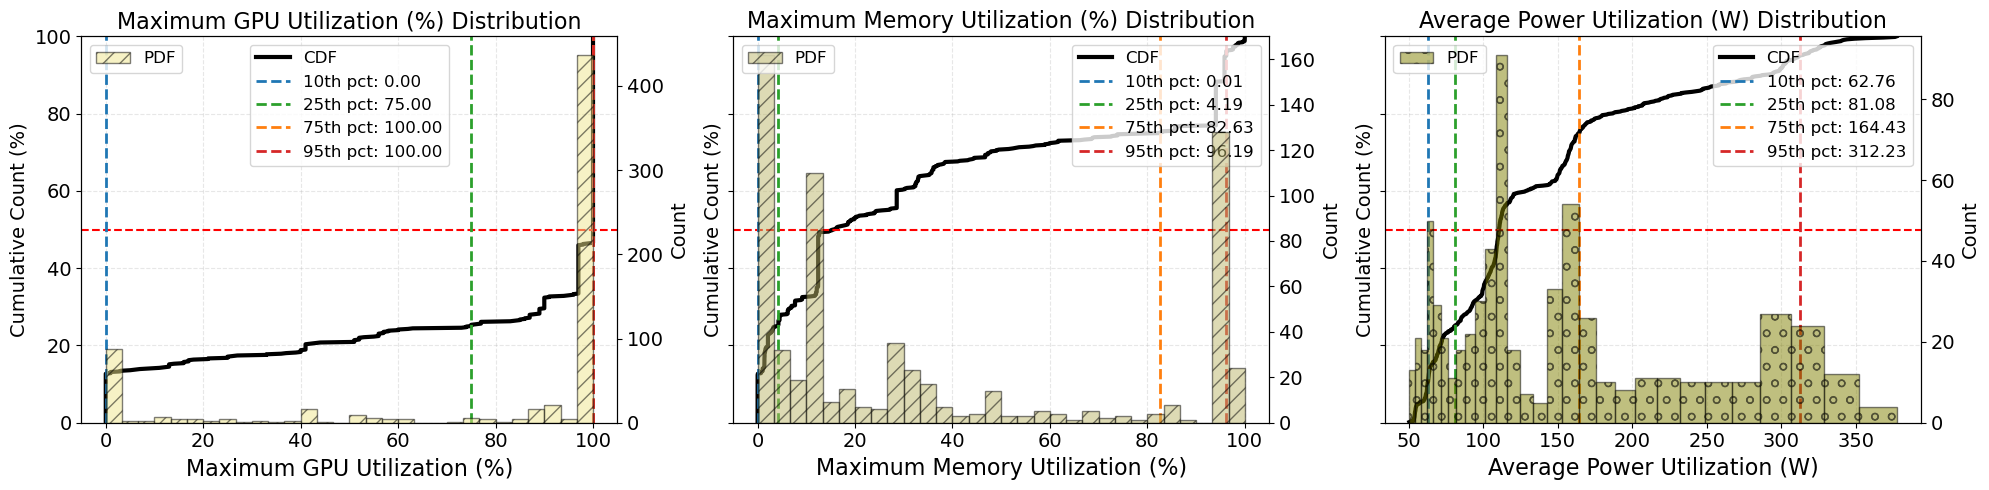

In [11]:
subplot_util_dist(atlas_data, 'gpu_utilization_max' , 'mem_util_max', 'avg_power', 'Perlmutter Atlas Jobs Resource Utilization Distributions (March 2025)', 'khaki', 'darkkhaki', 'olive' )


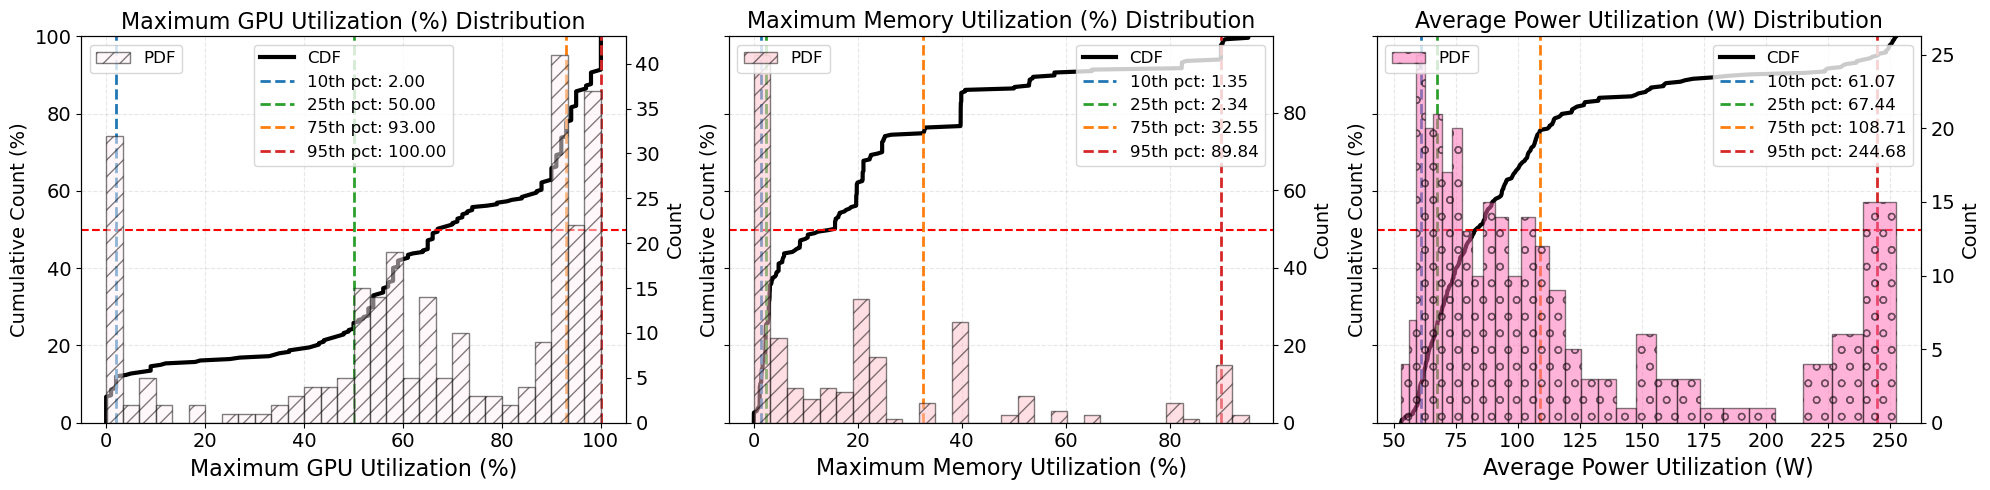

In [12]:
subplot_util_dist(e3sm_data, 'gpu_utilization_max' , 'mem_util_max', 'avg_power', 'Perlmutter E3SM Jobs Resource Utilization Distributions (March 2025)', 'lavenderblush', 'pink', 'hotpink' )


Additional Data Analysis on VASP

/global/u2/b/boztop/dcgm_slurm_studies/notebooks/../scripts/plot_functions.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


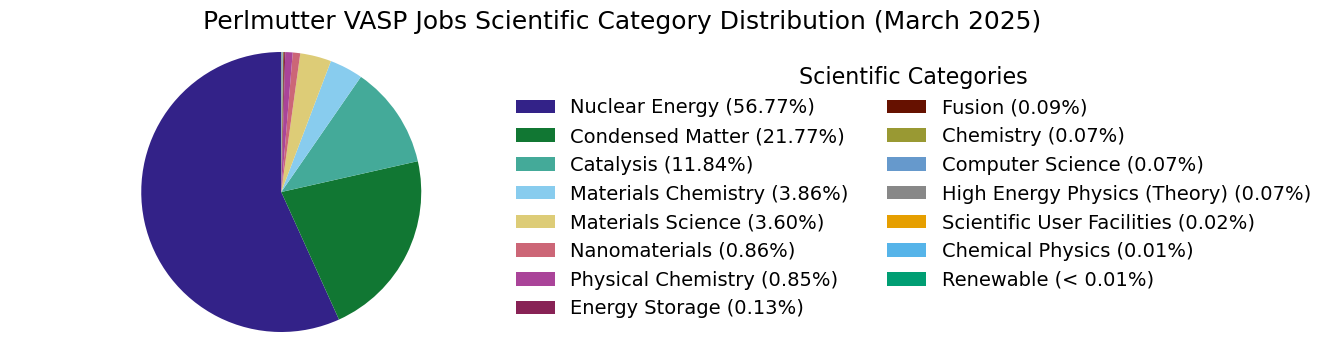

In [13]:
sci_cat_pie_chart(vasp_data)

In [14]:
# plot_util_dist(vasp_data, 'mem_util_max', '2025 March Perlmutter GPU Jobs GPU Memory Utilization (%)',color='#CC6677')  
# plot_util_dist(vasp_data, 'gpu_utilization_max', '2025 March Perlmutter VASP Jobs GPU Utilization (%)',color='#44AA99')  
# plot_power_dist(power_df, 'max_power', '2025 March Perlmutter VASP Jobs Maximum Power Usage (Watts)', color="#AA4499")
# plot_energy_dist(vasp_data, 'total_energy_kwh', '2025 March Perlmutter VASP Jobs Total Energy Consumption (kWh)', color="#DDCC77")


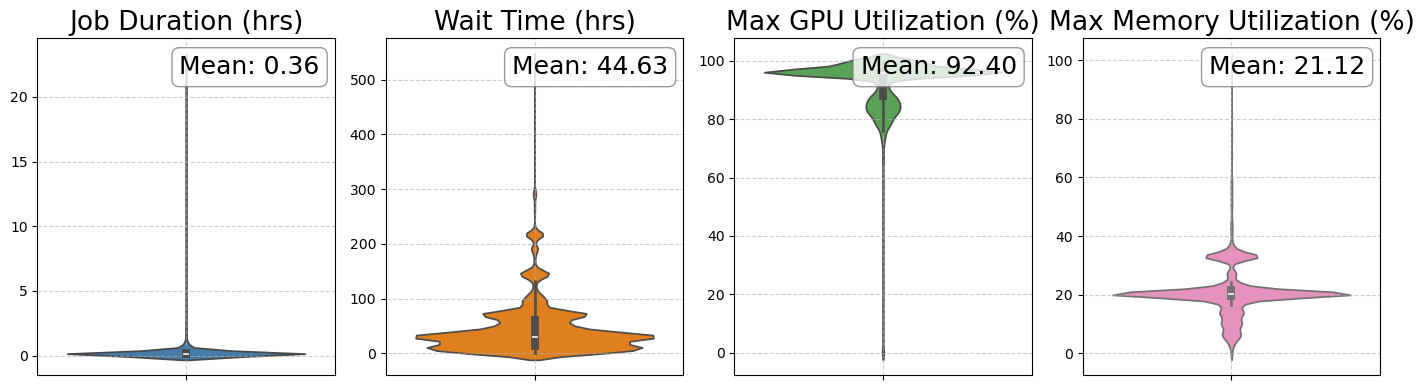

In [15]:
plot_job_summary_violin(vasp_data)

Scientific Category Distribution of VASP

Arithmetic Intensity (AI) Metric Visualization

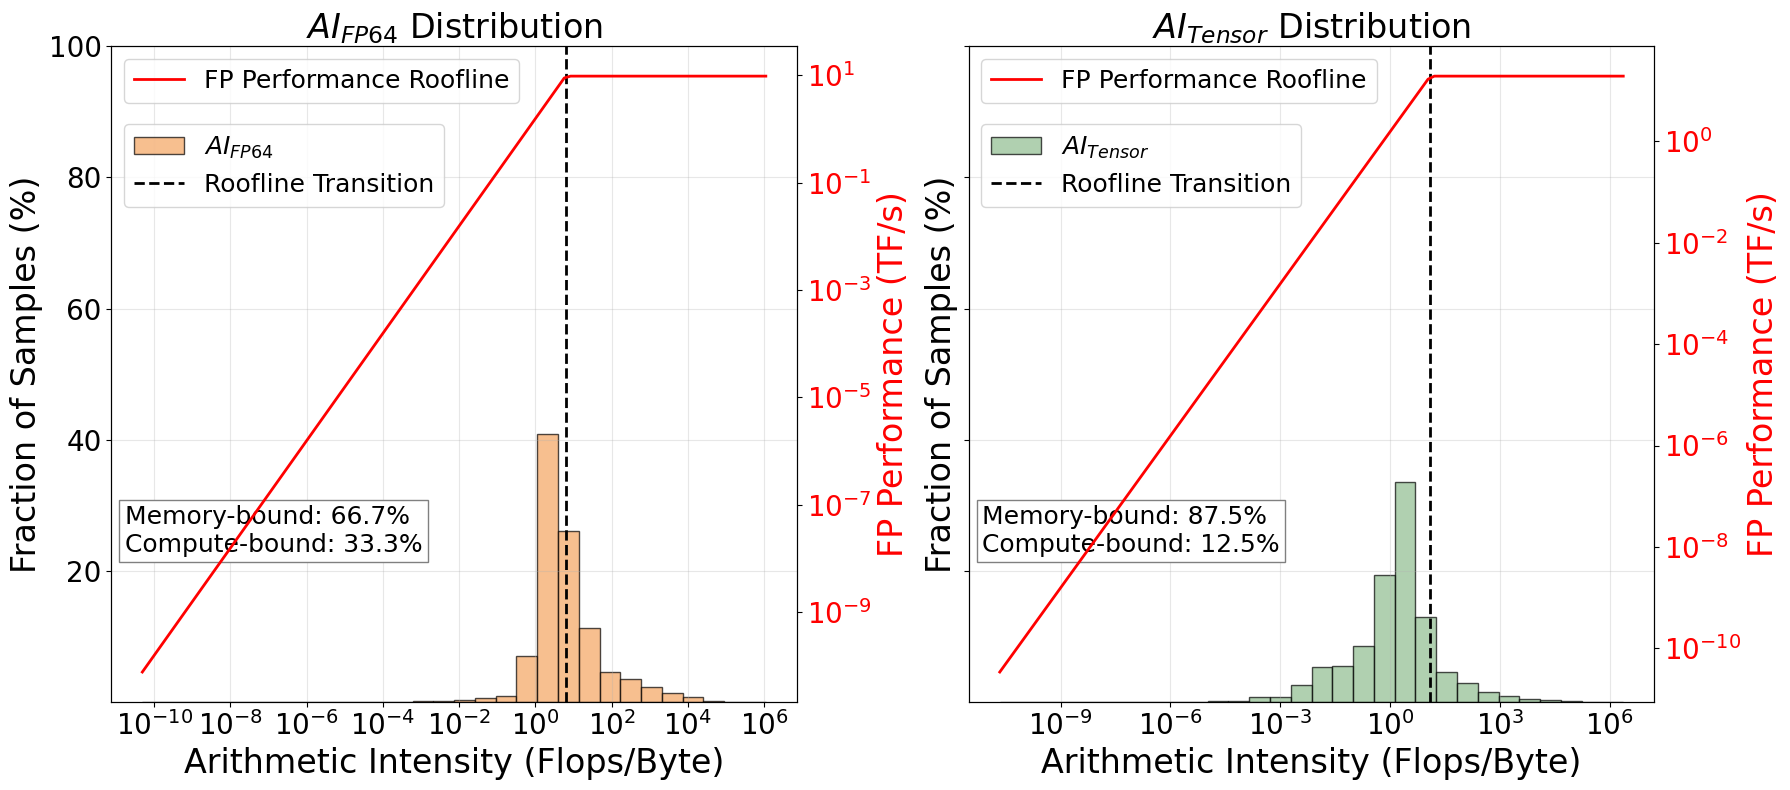

In [16]:
# plot_fp_heatmap(vasp_data,'total_fp64','total_tensor')
subplot_ai_dist(vasp_data, 'AI_fp64', 'AI_tensor', r'$AI_{FP64}$', r'$AI_{Tensor}$', 'Perlmutter VASP Jobs Arithmetic Intensity Distributions (March 2025)', color_1='sandybrown', color_2='darkseagreen')


In [18]:
# plot_ai_dist(vasp_data, 'p-AI_fp64-max', 'Arithmetic Intensity Distribution for VASP Jobs (FP64 Tensor)', r'$AI_{Tensor}$', color = 'darkseagreen')
# plot_ai_dist(vasp_data, 'p-AI_tensor-max', 'Arithmetic Intensity Distribution for VASP Jobs (FP64)', r'$AI_{FP64}$', color = 'sandybrown')


Visualize Temporal Imbalance Factors

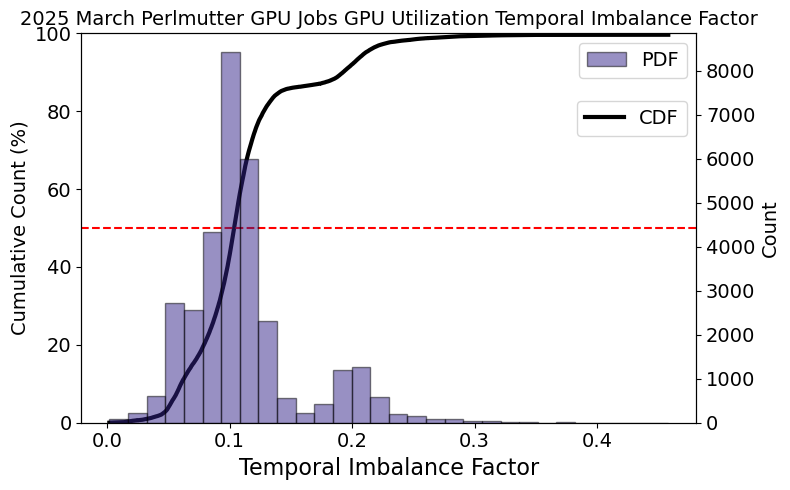

In [19]:
plot_tif_dist(vasp_data, 'gpu_tif_merged', '2025 March Perlmutter GPU Jobs GPU Utilization Temporal Imbalance Factor')


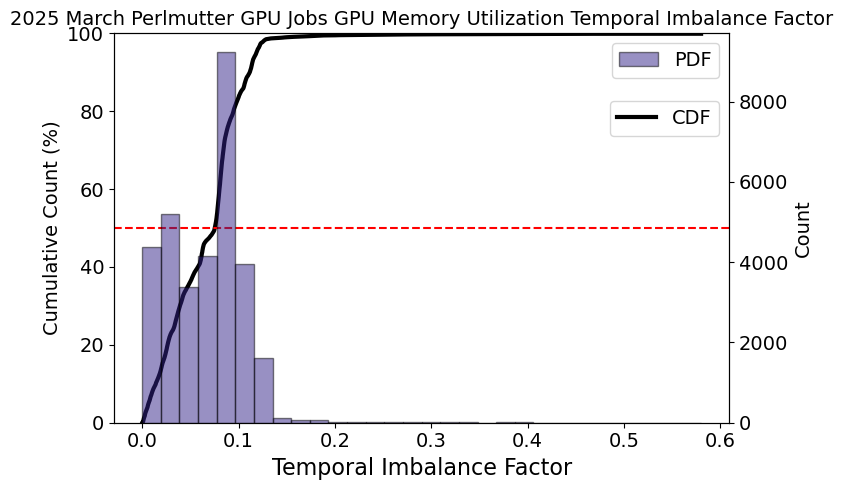

In [20]:
plot_tif_dist(vasp_data, 'mem_tif_merged', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Temporal Imbalance Factor')


Visualize Spatial Imbalance Factors

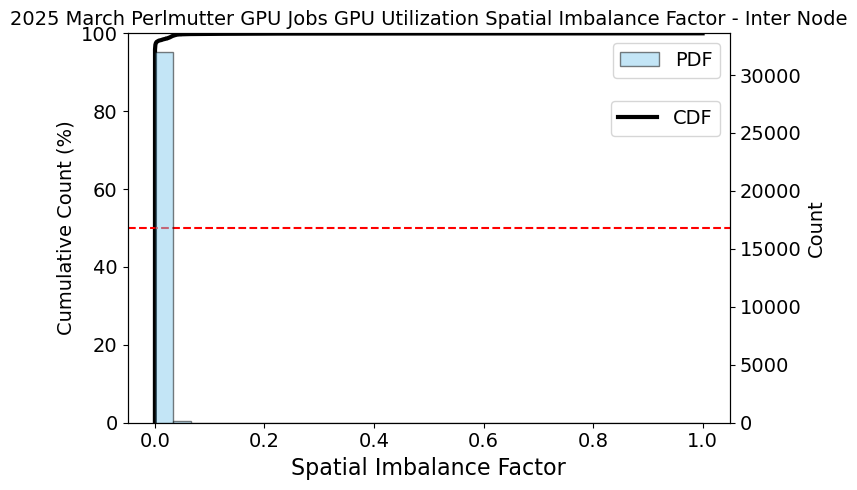

In [21]:
plot_sif_dist(vasp_data, 'gpu_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Inter Node')


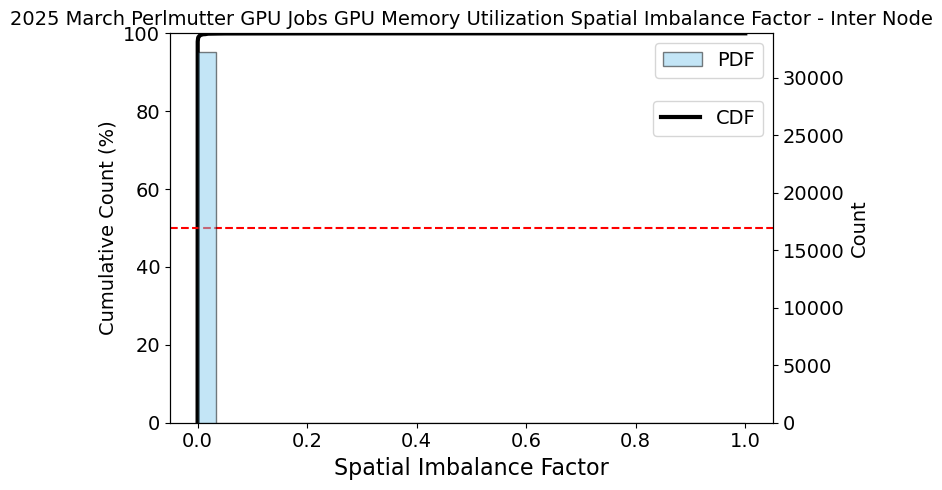

In [22]:
plot_sif_dist(vasp_data, 'mem_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Inter Node')


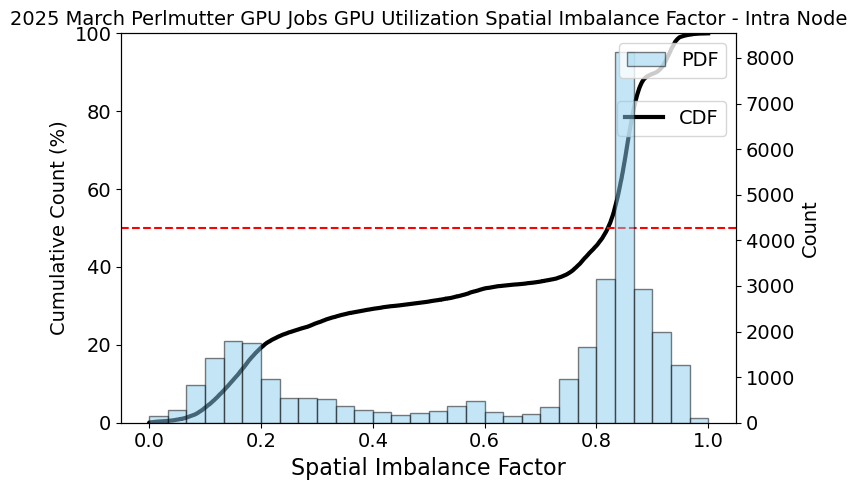

In [23]:
plot_sif_dist(vasp_data, 'gpu_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Intra Node')



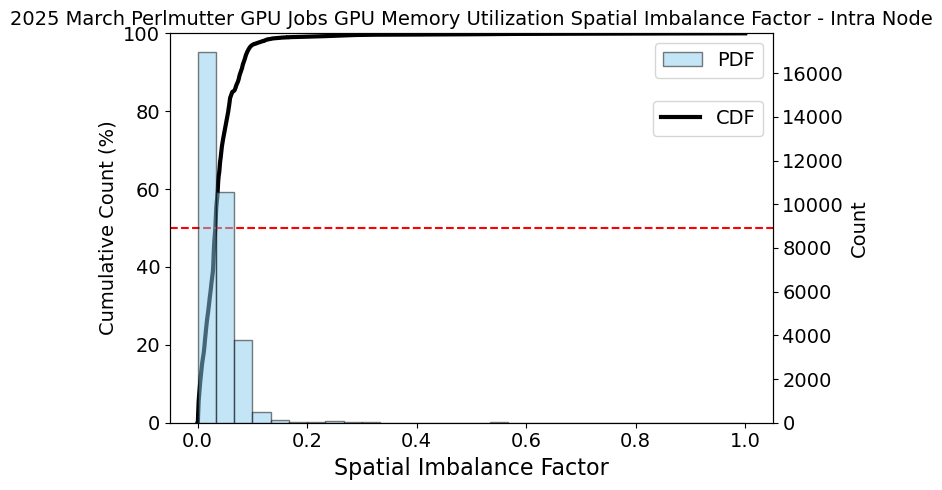

In [24]:
plot_sif_dist(vasp_data, 'mem_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Intra Node')


In [ ]:
# Note: Temporal and spatial imbalances are calculated following this paper:
'''
Efe Sencan, Dhruva Kulkarni, Ayse Coskun, and Kadidia Konate. 2025. 
Analyzing GPU Utilization in HPC Workloads: Insights from Large-Scale Systems. 
In Practice and Experience in Advanced Research Computing 2025: The Power of Collaboration (PEARC '25). 
Association for Computing Machinery, New York, NY, USA, Article 14, 1–8. 
https://doi.org/10.1145/3708035.3736010
'''